##RFM (Recency, Frequency, Monetary)
RFM analysis is a marketing technique used to quantitatively rank and group customers based on their purchase history to identify the best customers and understand their behavior.

The RFM model helps in segmenting customers into various categories, typically for targeted marketing campaigns. It considers the following three factors:

*   List Recency (R): How recently a customer has made a purchase. Customers who have purchased recently are more likely to respond to new offers.
*   Frequency (F): How often a customer makes a purchase. A higher frequency indicates a loyal customer.
*   Monetary Value (M): How much money a customer spends on purchases. Customers who spend more are often considered more valuable.




##Customer Lifetime Value (CLV)
"Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship". Customer lifetime value (CLV) can help us to answers the most important questions about sales to every company:
- How to Identify the most profitable customers?
- How can a company offer the best product and make the most money?
- How to segment profitable customers?
- How much budget need to spend to acquire customers?

In [1]:
!pip install lifetimes

In [2]:
#Import necessary libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes import GammaGammaFitter
%matplotlib inline

In [3]:
#Import Data
df = pd.read_csv("/content/sample_data/UK Retail Data.csv", index_col=0)
df.head()

,InvoiceDate,CustomerID,Quantity,UnitPrice,Total_Purchase,Country
InvoiceNo,,,,,,
536365,2010-12-01,17850.0,6,2.55,15.30,United Kingdom
536365,2010-12-01,17850.0,6,3.39,20.34,United Kingdom
536365,2010-12-01,17850.0,8,2.75,22.00,United Kingdom
536365,2010-12-01,17850.0,2,7.65,15.30,United Kingdom
536365,2010-12-01,17850.0,6,4.25,25.50,United Kingdom


In [4]:
#Check the Last order date
last_order_date = df['InvoiceDate'].max()
print(last_order_date)

2011-12-09


##Online Retail Data contains transactions from 01/12/2010 and 09/12/2011.

In [5]:
#Check the number of columns and rows in the dataset
df.shape

(220338, 6)

In [6]:
#Check for missing values in the dataset
df.isnull().sum(axis=0)

InvoiceDate       0
CustomerID        0
Quantity          0
UnitPrice         0
Total_Purchase    0
Country           0
dtype: int64

In [7]:
#Validate if there are any negative values in Quantity column
df.Quantity.min()

1

In [8]:
#Set Latest date 2011-12-10 as last invoice date was 2011-12-09.
#This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

## RFM Modelling: To predict customer value

In [9]:
#Use Lifetimes package to transform the transactional data (one row per purchase)
#into summary data (frequency, recency, age and monetary).

rfm = summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Total_Purchase',
    observation_period_end=pd.to_datetime('2011-12-9')  # Adjust this to your dataset's last date
)
print(rfm.head())


            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0        0.000000
12747.0          10.0    367.0  369.0      346.173000
12748.0         113.0    373.0  373.0      227.779292
12749.0           3.0    210.0  213.0      696.106667
12820.0           3.0    323.0  326.0      173.600000


count    3921.000000
mean        2.849783
std         5.717734
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       113.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.68 %


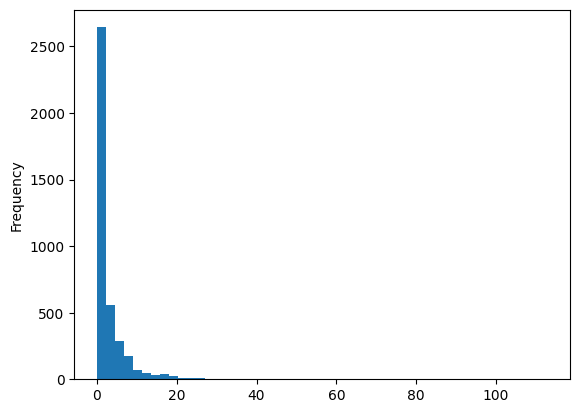

In [10]:
#Create histogram to find out how many customers purchased item only once.
rfm['frequency'].plot(kind='hist', bins=50)
print(rfm['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(rfm['frequency'] == 0)/float(len(rfm))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

##Frequency/Recency Analysis Using the BG/NBD Model

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])


<lifetimes.BetaGeoFitter: fitted with 3921 subjects, a: 0.01, alpha: 69.62, b: 7.96, r: 0.83>

In [12]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.833309,0.028543,0.777365,0.889253
alpha,69.621310,2.787483,64.157844,75.084777
a,0.005501,0.013943,-0.021827,0.032829
b,7.960054,23.158462,-37.430531,53.350639


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

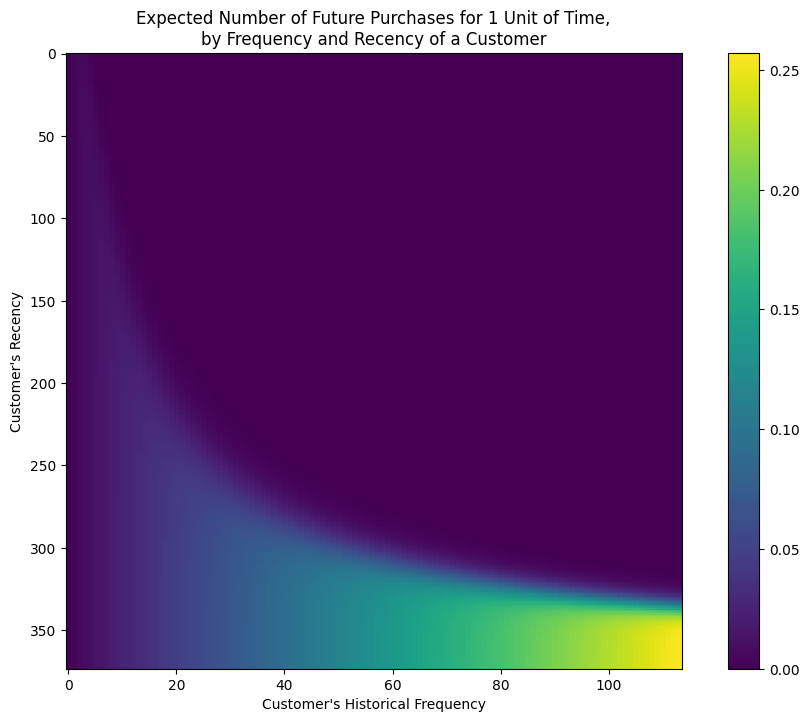

In [13]:
#Visualizing our frequency/recency matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

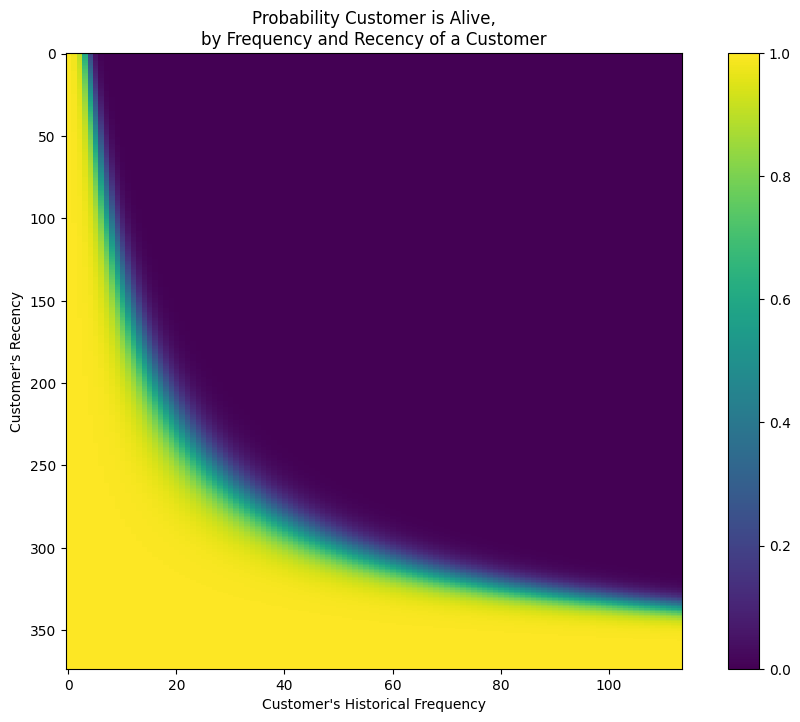

In [14]:
#predict if the customers are surely alive:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [15]:
#Predict future transaction i.e. top 10 customers that the model expects to make purchases in the next 10 days

t = 10
rfm['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'], rfm['recency'], rfm['T']),2)
rfm.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,12748.0,113.0,373.0,373.0,227.779292,2.57
1,17841.0,111.0,372.0,373.0,264.481081,2.53
2,15311.0,89.0,373.0,373.0,485.150899,2.03
3,14606.0,88.0,372.0,373.0,111.485000,2.01
4,12971.0,70.0,369.0,372.0,146.307857,1.60
5,13089.0,65.0,367.0,369.0,639.646923,1.50
6,14527.0,53.0,367.0,369.0,128.871887,1.23
7,13798.0,52.0,371.0,372.0,609.793269,1.20
8,16422.0,47.0,352.0,369.0,642.026383,1.09
9,14096.0,16.0,97.0,101.0,2392.833125,0.99


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

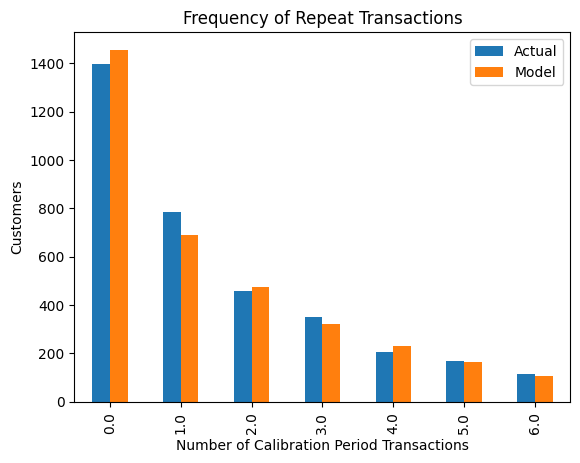

In [16]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [17]:
#Customer's future transaction prediction for next 10 days

t = 10
individual = rfm.loc[12748]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

2.571530562897844

##Observation: Our model predicts that for customer 12748’s future transaction is approximately 3 in 10 days.

In [18]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
rfm[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.027996
frequency,0.027996,1.000000


In [19]:
#Shortlist customers who had at least one repeat purchase with the company.
shortlisted_customers = rfm[rfm['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12747.0       10.0    367.0  369.0      346.173000          0.25
1     12748.0      113.0    373.0  373.0      227.779292          2.57
2     12749.0        3.0    210.0  213.0      696.106667          0.14
3     12820.0        3.0    323.0  326.0      173.600000          0.10
4     12822.0        1.0     17.0   87.0      182.330000          0.12
-----------------------------------------
The Number of Returning Customers are:  2522


In [20]:
#Train gamma-gamma model by taking into account the monetary_value.
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 2.37, q: 3.90, v: 347.73>


In [21]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer.
print(ggf.conditional_expected_average_profit(rfm['frequency'],
                                              rfm['monetary_value']).head(10))

CustomerID
12346.0    284.411533
12747.0    339.444458
12748.0    228.385484
12749.0    576.902863
12820.0    205.684800
12821.0    284.411533
12822.0    238.483464
12823.0    344.889358
12824.0    284.411533
12826.0    131.032810
dtype: float64


In [22]:
rfm['pred_txn_value'] = round(ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                        rfm['monetary_value']), 2)
rfm.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,284.41
1,12747.0,10.0,367.0,369.0,346.173000,0.25,339.44
2,12748.0,113.0,373.0,373.0,227.779292,2.57,228.39
3,12749.0,3.0,210.0,213.0,696.106667,0.14,576.90
4,12820.0,3.0,323.0,326.0,173.600000,0.10,205.68


##CLV Analysis

In [23]:
#Calculate Customer Lifetime Value
rfm['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

rfm.drop(rfm.iloc[:, 0:6], inplace=True, axis=1)

rfm.sort_values(by='CLV', ascending=False).head(10).reset_index()

,CustomerID,CLV
0,16446.0,170921.97
1,17450.0,126936.71
2,18102.0,115951.87
3,14096.0,74478.90
4,16029.0,48814.73
5,17511.0,45397.19
6,17949.0,42923.30
7,16684.0,41658.52
8,15311.0,33003.36
9,13694.0,32844.14
